Author: Felix Molter  
Email: felixmolter@gmail.com  
Date: 10/11/2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir

%matplotlib inline
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import ttest_rel
from tqdm.notebook import tqdm

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

In this notebook, I will detail the process of how we selected the task used in the study.
The code for implementation of the tasks, agents, and parameter estimation is heavily inspired by code from Rasmus Bruckner, available at https://github.com/rasmusbruckner/gaborbandit_analysis.
The functions used in this notebook are available at the corresponding github repository (https://github.com/moltaire/rl).

# Behavioural model: Dual-learning-rate delta-rule agent

In the research project, we aim to investigate the relationship between specific dietal components (i.e., large macronutrients effectively acting as precursoors for dopamine and serotonin) and specific aspects of reinforcement learning behaviour.
In particular, we hypothesize that different aspects of the diet differentially affect learning from positive vs. negative prediction errors. Therefore, we adapt a model of learning behaviour, that different learning rates for outcomes that produce positive and negative prediction errors.

Formally, we assume that the agent has a value estimate $Q_{s, a}$ for each action $a$ in a state $s$, and updates these using a simple $\delta$ learning rule.

Specifically, the reward prediction error at the end of a trial is given by

$$\delta(t) = r(t) - Q_{s, a}(t)$$

where $Q_{s, a}(t)$ is the current value estimate of the chosen action $a$ in the current state $s$, and $r(t)$ is the current received reward. The value estimate is then updated according to

$$Q_{s, a}(t+1) = Q_{s, a}(t) + \alpha \delta(t)$$

where $\alpha$ is set to $\alpha^+$ if $\delta(t) > 0$ and $\alpha^-$ otherwise.

We assume that the agent's choices are probabilistic and that the probability of choosing action $a$ in state $s$ is derived from a softmax function, over the current value estimates $Q_{s, a}(t)$:

$$p_{a, s}(t) = \frac{e^{\beta Q_{s, a}(t)}}{\sum_i e^{\beta Q_{s, i}(t)}}$$

where $\beta$ is a temperature parameter controlling the degree to which choices are deterministic.

# Tasks considered

For this project, we require the task to satisfy two criteria: First, it needs to provide data from which the agents' two learning rate parameters can be estimated reliably, within a limited number of trials. Second, it needs to provide a setting in which participants' behaviour is adequately described by our model, the delta-rule dual-learning-rate agent.

We consider two different tasks from prior reinforcement learning work:

## Reversal Learning

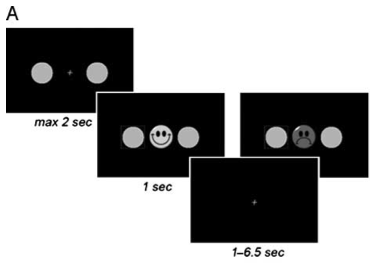  

**Figure 1A.** Structure of the dynamic decision-making task. Subjects first saw two targets for up to 2 sec (or reaction time). After selecting one with a button press, a blue frame surrounded the chosen target and either positive (reward) or negative (loss) feedback (reward or loss, left or right middle panel, respectively) was shown for 1 sec. Then, a fixation cross was shown for 1 to 6.5 sec. (Figure and caption from Kahnt, Park et al., 2009)

The reversal-learning task was used for example in Kahnt, Park et al. (2009). In each trial, participants choose between one of two alternatives (left or right), which are associated with different probabilities of reward P. The reward probabilities of the left and right alternatives stay constant for a number of trials (an *episode*), before they switch to another set of possible reward probabilities. These sets of reward probabilities can be considered different *states*, but they are not observable for the participant. The original paper used three different states: 20:80 (where the right alternative is rewarded more frequently), 50:50 (equal probability of reward for both alternatives) and 80:20 (left alternative rewarded more frequently). The state was changed randomly to one of the other states after a minimum of 10 trials and a minimum accuracy of 70%, or after a maximum of 16 trials. This study only used smiley and frowney faces as positive and negative reward signals, respectively.
In sum, participants have to learn the reward probabilities of each side within each episode, and adapt their learning after a state change.

## Multiple Observable States

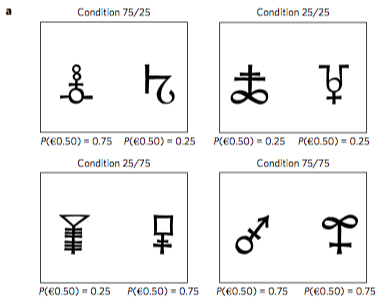  
**Figure 1a.** The task’s conditions and contingencies. Subjects selected between left and right symbols. Each symbol was associated with a stationary probability (P = 0.25 or 0.75) of winning €0.50 and a reciprocal probability (1 – P) of getting nothing (first experiment) or losing €0.50 (second experiment). In two conditions (rightmost column), the reward probability was the same for both symbols (‘symmetric’ conditions), and in two other conditions (leftmost column), the reward probability was different across symbols (‘asymmetric’ conditions). Note that the symbols-to-conditions assignment was randomized across subjects. (Figure and caption from Lefebvre et al., 2017)

The multiple-observable-state task is used in Lefebvre et al. (2017) and other prior work.
In each trial, participants choose between two different symbols that are probabilistically associated with a reward, such that a symbol yielded a reward $r^+$ with probability P, and otherwise no reward (in Experiment 1) or a negative reward $r^-$ (Experiment 2).
Participants had to learn the reward probabilities associated with each symbol in each state to make good decisions.
Four different pairs of symbols (i.e., states), with different reward probabilities were used. In two of these states, one symbol was associated with a higher reward probability, whereas in the other two states, both options had the same probability of reward.

# Replication of Lefebvre et al., 2017

In this section, I will replicate the task and agent modeling and parameter estimation used in Lefebvre et al. (2017). This serves two purposes:

1. Validate our implementations of the task and agent
2. Provide a set of realistic, individual parameter estimates. These can be used for parameter recovery.

In [3]:
DATA_DIR = join("datasets", "lefebvre_2017_nhb")

In [4]:
def read_process_mat(matfile, experiment):
    """This function reads a .mat file from the Lefebvre data
    and transforms it into a pandas DataFrame.
    
    Args:
        matfile (str): Path to the .mat file.
        experiment (int): One of [1, 2]. Indicate the experiment, from which the data file is.
            Background: The data files differ in their columns, so we have to be explicit about it.
    
    Returns:
        pandas.DataFrame: Formatted data.
    """
    # Extract subject ID
    subject = int(re.findall("_\d+.mat", matfile)[0][1:-4])

    # Read .mat file and convert to DataFrame with named columns
    if experiment == 1:
        columns = ["_", "trial", "s", "_", "_", "_", "a", "r", "_"]
    elif experiment == 2:
        columns = ["_", "trial", "s", "_", "a", "_", "_", "r"]
    x = loadmat(matfile)
    df = pd.DataFrame(x["data"], columns=columns)

    # Reformat variables
    df["subject"] = subject
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["block"] = 0
    df["a"] = (df["a"] / 2 + 0.5).astype(
        np.int32
    )  # Transform action from [-1, 1] to [0, 1]
    df["s"] = (df["s"] - 1).astype(
        np.int32
    )  # Transform states from [1, 2, 3, 4] to [0, 1, 2, 3]
    if experiment == 1:
        df["r"] = df["r"] / 2  # Transform rewards from [0, 1] to [0, 0.5]

    return df[["subject", "block", "trial", "s", "a", "r"]]


df = read_process_mat(join(DATA_DIR, "data_exp1", "exp1_4.mat"), experiment=1)
df.head()

,subject,block,trial,s,a,r
0,4,0,0,0,0,0.0
1,4,0,1,0,0,0.0
2,4,0,2,0,1,0.0
3,4,0,3,0,0,0.5
4,4,0,4,1,0,0.5


This dataframe has the following columns:
1. `subject`: Subject ID
2. `block`: Experiment block (there was only one block)
3. `trial`: Trial number
4. `s`: Trial state (which pair of symbols was shown)
5. `a`: The agents' response (0 = left, 1 = right)
6. `r`: Reward

## Preparation

In [5]:
# Define the general characteristics of the task
task_vars = rl.task.TaskVars(n_trials=96, n_blocks=1, n_options=2, n_states=4)

# Initialize estimation variables
# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 20)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,  # Number of estimation runs
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

## Experiment 1

In the Experiment 1, no losses were used: $r^+$ was 0.5, and $r^-$ was simply 0.

In [6]:
# Initialize agent_vars (for initial Q values). Q_init was 0.25 in Experiment 1
agent_vars = rl.agent.AgentVars(Q_init=np.ones((4, 2)) * 0.25, variant="delta")

matfiles = [
    file for file in listdir(join(DATA_DIR, "data_exp1")) if file.endswith(".mat")
]

results_exp1 = []

for matfile in tqdm(matfiles):

    # Subject DataFrame
    filename = join(DATA_DIR, "data_exp1", matfile)
    df_s = read_process_mat(filename, experiment=1)
    subject = df_s["subject"][0]

    # Now we can estimate the maximum likelihood parameters
    result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

    # Save results to DataFrame
    result_df = pd.DataFrame(
        dict(
            subject=subject,
            nll=result[0],
            bic=result[1],
            alpha_pos=result[2][0],
            alpha_neg=result[2][1],
            beta=result[2][2],
        ),
        index=[subject],
    )
    results_exp1.append(result_df)

results_exp1 = pd.concat(results_exp1).sort_values("subject")
results_exp1.to_csv("lefebvre-2017_exp1_RWpn-estimates.csv")

In [7]:
results_exp1["1/beta"] = 1.0 / results_exp1["beta"]
results_exp1[["nll", "bic", "alpha_pos", "alpha_neg", "1/beta"]].describe().round(2)

,nll,bic,alpha_pos,alpha_neg,1/beta
count,50.00,50.00,50.00,50.00,50.00
mean,40.67,95.03,0.41,0.18,0.11
std,15.66,31.32,0.30,0.29,0.12
min,9.69,33.07,0.00,0.00,0.05
25%,26.59,66.87,0.21,0.00,0.05
50%,41.21,96.11,0.32,0.06,0.08
75%,53.47,120.64,0.47,0.18,0.13
max,65.32,144.33,1.00,1.00,0.80


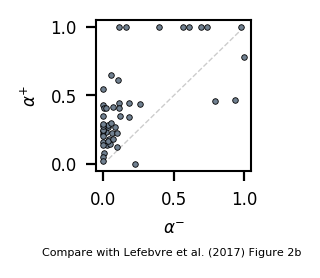

In [8]:
fig, ax = plt.subplots(figsize=(1, 1), dpi=200)
ax.plot(results_exp1["alpha_neg"], results_exp1["alpha_pos"], "o", markeredgewidth=0.3)
ax.set_xlabel(r"$\alpha^{-}$")
ax.set_ylabel(r"$\alpha^{+}$")
ax.plot([0, 1], [0, 1], "--k", alpha=0.2, zorder=-1, lw=0.5)
plt.figtext(
    0.5,
    -0.3,
    "Compare with Lefebvre et al. (2017) Figure 2b",
    wrap=True,
    horizontalalignment="center",
    fontsize=4,
);

These values are similar to the ones reported in the paper. They are not identical. However, some variation is expected, due to possible differences in parameterization (e.g., estimation of $\frac{1}{\beta}$ instead of $\beta$), parameter boundaries, the specific optimization algorithm, and due to the stochastic nature of the opmization, noise.
In sum, this estimation is largely in line with the results reported in the paper, lending support for our implementation of the agent, and the estimation procedure.

## Experiment 2

Experiment 2 resembled Experiment 1, but involved losses: $r^-$ was set to -0.5.

In [9]:
# Q_init = 0 in Experiment 2
agent_vars = rl.agent.AgentVars(Q_init=np.zeros((4, 2)), variant="delta")

matfiles = [
    file for file in listdir(join(DATA_DIR, "data_exp2")) if file.endswith(".mat")
]

results_exp2 = []

for matfile in tqdm(matfiles):

    # Subject DataFrame
    filename = join(DATA_DIR, "data_exp2", matfile)
    df_s = read_process_mat(filename, experiment=2)
    subject = df_s["subject"][0]

    # Now we can estimate the maximum likelihood parameters
    result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

    # Save results to DataFrame
    result_df = pd.DataFrame(
        dict(
            subject=subject,
            nll=result[0],
            bic=result[1],
            alpha_pos=result[2][0],
            alpha_neg=result[2][1],
            beta=result[2][2],
        ),
        index=[subject],
    )
    results_exp2.append(result_df)

results_exp2 = pd.concat(results_exp2).sort_values("subject")
results_exp1.to_csv("lefebvre-2017_exp2_RWpn-estimates.csv")

In [10]:
results_exp2["1/beta"] = 1.0 / results_exp2["beta"]
results_exp2[["nll", "bic", "alpha_pos", "alpha_neg", "1/beta"]].describe().round(2)

,nll,bic,alpha_pos,alpha_neg,1/beta
count,35.00,35.00,35.00,35.00,35.00
mean,39.24,92.16,0.43,0.13,0.29
std,17.12,34.23,0.32,0.21,0.53
min,12.26,38.21,0.00,0.00,0.05
25%,26.33,66.36,0.18,0.00,0.05
50%,38.79,91.26,0.32,0.04,0.13
75%,52.57,118.83,0.65,0.17,0.27
max,66.49,146.66,1.00,1.00,2.98


As for Experiment 1, these estimates are similar to the ones reported in the paper, yet not identical. The largest deviation comes from the $\beta$ parameter, which we attribute to differences in paramterization and parameter boundaries. These differences in the parameter most likely do not relate to meaningful differences in behaviour.

In sum, replicating the analyses from Lefebvre et al. (2017) our implementation of the dual-learning-rate delta-rule agent and the parameter estimation procedure seems valid.

# Parameter recoveries

Next, we will test how well the learning rate parameters can be recovered from behaviour in the two tasks, for varying numbers of trials. To this end, we simulate behaviour from agents interacting with different versions of the tasks, estimate the parameters from the resulting data, and finally compare the recovered to the true generating parameters.

Importantly, we use sets of parameter estimates corresponding to the estimates obtained from fitting the model to the Lefebvre et al. (2017) data. This ensures that we recover parameters in a space where they actually relate to realistic, observed behaviour. By sampling sets of parameters (in contrast to sampling each parameter independently from the set of estimated parameters) we also account for the fact that parameters might depend on each other. For example, it could be that one parameter cannot be recovered well if another parameter has a certain value.

In [11]:
lefebvre_results = pd.concat([results_exp1, results_exp2]).reset_index(drop=True)
lefebvre_results.head()

,subject,nll,bic,alpha_pos,alpha_neg,beta,1/beta
0,1,54.705569,123.104182,1.000000,0.733966,4.388797,0.227853
1,2,25.616836,64.926717,0.227349,0.063845,20.000000,0.050000
2,3,40.401778,94.496600,0.183101,0.042253,20.000000,0.050000
3,4,49.898995,113.491035,0.648845,0.051446,8.298984,0.120497
4,5,48.736446,111.165936,0.220194,0.000000,9.063293,0.110335


In [12]:
# General settings
np.random.seed(1)

n_trials = 50  # numbers of trials per block
n_sp = 2  # numbers of estimation starting points
N = len(lefebvre_results)
block_range = range(1, 7)  # range of number of blocks to be varied

parameter_values = dict(
    alpha_pos=lefebvre_results["alpha_pos"].values,
    alpha_neg=lefebvre_results["alpha_neg"].values,
    beta=lefebvre_results["beta"].values,
)

## Reversal Learning task

We will test recoverability for four variants of the reversal-learning task. These are obtained by combining two state sets and two transition sets. The first state set corresponds to the one used in Kahnt, Park et al. (2009). The second state set is identical, but without the 50:50 condition, where both actions are equally likely to yield rewards.
The first transition set is identical to the one used in Kahnt, Park et al. (2009). For the second transition set, we decreased the minimum number of correct responses to 5 and increased the maximum number of trials per episode to 20. Note that we scaled the reward to 0.5, the same value as was used in Lefebvre et al. (2017), so that parameter values are compatible.

We also vary the number of blocks between 1 and 6, with 50 trials per block, to test recovery performance as a function of trial count.

For each variant and block count, we simulate data from 85 participants (each corresponding to one participant in the Lefebvre data) with known parameters and then estimate the parameters of the synthetic data.

In [13]:
rv_state_sets = {
    "A": {
        0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
        1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
        2: {"p_r": [0.5, 0.5], "a_correct": [0, 1], "rewards": [0.5, 0]},
    },
    "B": {
        0: {"p_r": [0.2, 0.8], "a_correct": [1], "rewards": [0.5, 0]},
        1: {"p_r": [0.8, 0.2], "a_correct": [0], "rewards": [0.5, 0]},
    },
}

rv_transition_sets = {
    "X": {
        "n_trials_reversal_min": 10,
        "n_trials_reversal_max": 16,
        "p_correct_reversal_min": 0.7,
    },
    "Y": {
        "n_trials_reversal_min": 5,
        "n_trials_reversal_max": 20,
        "p_correct_reversal_min": 0.7,
    },
}

In [ ]:
results_rv = []

pbar = tqdm(total=len(rv_state_sets) * len(rv_transition_sets) * len(block_range))

for state_set_label, state_set in rv_state_sets.items():
    for transition_set_label, transition_set in rv_transition_sets.items():
        for n_blocks in block_range:

            # Set up task
            rv_task_vars = rl.task.TaskVars(
                n_trials=n_trials,
                n_blocks=n_blocks,
                n_options=2,
                states=state_set,
                n_trials_reversal_min=transition_set[
                    "n_trials_reversal_min"
                ],  # minimum number of trials before reversal
                n_trials_reversal_max=transition_set[
                    "n_trials_reversal_max"
                ],  # maximum number of trials without reversal
                p_correct_reversal_min=transition_set[
                    "p_correct_reversal_min"
                ],  # minimum accuracy before reversal before `n_trials_reversal_max`
            )
            rv_task = rl.task.ReversalLearningTask(task_vars=rv_task_vars)

            # Set up agent
            # Use mean parameters from Lefebvre et al. (2017)
            agent_vars = rl.agent.AgentVars(
                alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant="delta"
            )
            agent = rl.agent.DualLearningRateAgent(
                agent_vars=agent_vars, n_options=rv_task.task_vars.n_options
            )

            # Set up estimation
            # Define parameters to estimate
            parameters = ["alpha_pos", "alpha_neg", "beta"]

            # Set boundaries (used to initialize and constrain estimation)
            bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

            # Initialize estimation variables and estimation instance
            # Note, that we also need to specify the agent_class (i.e., the agent "model")
            est_vars = rl.estimation.EstimationVars(
                rv_task_vars,
                agent_class=rl.agent.DualLearningRateAgent,
                parameters=parameters,
                bounds=bounds,
                n_sp=n_sp,
            )
            est = rl.estimation.Estimation(est_vars)

            # Run recovery
            result = rl.recovery.run_estimate_recovery(
                task=rv_task,
                agent=agent,
                est=est,
                parameter_values=parameter_values,
                verbose=False,
            )
            result["state_set"] = state_set_label
            result["transition_set"] = transition_set_label
            result["task"] = "rv"
            result["variant"] = "delta"
            results_rv.append(result)
            pd.concat(results_rv).to_csv(
                "test_task_recovery_rv.csv"
            )  # intermediate save
            pbar.update(1)

results_rv = pd.concat(results_rv)
results_rv.to_csv("test_task_recovery_rv.csv")

## Multiple Observable States task

For this task, we consider the state sets from Lefebvre et al. (2017) Experiments 1 and 2, respectively. The state sets are identical, except for the fact that in Experiment 2 the non-reward outcome $r^-$ was set to -0.5 instead of 0.

Note, that due to there being four different states, which are supposed to be presented equally often, block length was set to 48, as 50 is not divisible by 4.

In [ ]:
ms_state_sets = {
    "gains-only": {
        0: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, 0]},
        1: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, 0]},
        2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, 0]},
        3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, 0]},
    },
    "gain-loss": {
        0: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
        1: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, -0.5]},
        2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, -0.5]},
        3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
    },
}

In [ ]:
results_ms = []

pbar = tqdm(total=len(ms_state_sets) * len(block_range))

for state_set_label, state_set in ms_state_sets.items():
    for n_blocks in block_range:

        # Build sequence of trials / states (n_blocks x n_trials)
        n_states = len(state_set)
        state_sequence = np.repeat(
            np.repeat(np.arange(n_states), n_trials // n_states)[:, None],
            n_blocks,
            axis=1,
        )

        ## Shuffle within each block
        [
            np.random.shuffle(state_sequence[:, block])
            for block in range(state_sequence.shape[1])
        ]

        # Set up task
        ms_task_vars = rl.task.TaskVars(
            n_options=2, states=state_set, state_sequence=state_sequence.T
        )
        ms_task = rl.task.MultipleStateTask(task_vars=ms_task_vars)

        # Set up agent
        # Use mean parameters from Lefebvre et al. (2017)
        agent_vars = rl.agent.AgentVars(
            alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant="delta",
        )
        agent = rl.agent.DualLearningRateAgent(
            agent_vars=agent_vars,
            n_options=ms_task.task_vars.n_options,
            n_states=n_states,
        )

        # Set up estimation
        # Define parameters to estimate
        parameters = ["alpha_pos", "alpha_neg", "beta"]

        # Set boundaries (used to initialize and constrain estimation)
        bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

        # Initialize estimation variables and estimation instance
        # Note, that we also need to specify the agent_class (i.e., the agent "model")
        est_vars = rl.estimation.EstimationVars(
            ms_task_vars,
            agent_class=rl.agent.DualLearningRateAgent,
            parameters=parameters,
            bounds=bounds,
            n_sp=n_sp,
        )
        est = rl.estimation.Estimation(est_vars)

        # Run recovery
        result = rl.recovery.run_estimate_recovery(
            task=ms_task,
            agent=agent,
            est=est,
            parameter_values=parameter_values,
            verbose=False,
        )
        result["state_set"] = state_set_label
        result["transition_set"] = "Z"
        result["task"] = "ms"
        result["variant"] = "delta"
        results_ms.append(result)
        pd.concat(results_ms).to_csv("test_task_recovery_ms.csv")  # intermediate save
        pbar.update(1)

results_ms = pd.concat(results_ms)
results_ms.to_csv("test_task_recovery_ms.csv")

## Results

We compute the summed mean squared error between true generating and recovered learning-rate parameters across synthetic participants:

In [ ]:
# Combine results
results = pd.concat([results_rv, results_ms]).reset_index(drop=True)
results.to_csv("test_task_recovery.csv")

# compute error for each individual i
for parameter in ["alpha_pos", "alpha_neg", "beta"]:
    results[f"error_{parameter}"] = (
        results[f"{parameter}_hat"] - results[parameter]
    ) ** 2
results["error_alpha_combined"] = (
    results["error_alpha_pos"] + results["error_alpha_neg"]
)

# Sum errors across participants (within each model variant and block count)
mean_error = results.groupby(["task", "state_set", "transition_set", "n_blocks"])[
    ["error_alpha_pos", "error_alpha_neg", "error_alpha_combined", "error_beta"]
].mean()

### For each task, which variant has the lowest error in recovered learning rates?

#### $\alpha^+$

In [ ]:
mean_error.sort_values("error_alpha_pos").groupby("task").head(1)["error_alpha_pos"]

For $\alpha^+$

- the reversal-learning task **without 50:50** state and transition set **Z**  
- the multiple state task **without losses**

work best and

- the **reversal-learning task** has slightly lower error.
- also, 4 blocks achieved lower error for the multiple state task than 6 blocks.

#### $\alpha^-$

In [ ]:
mean_error.sort_values("error_alpha_neg").groupby("task").head(1)["error_alpha_neg"]

For $\alpha^-$

- the reversal-learning task **without 50:50** state and with transition set **Y**  
- the multiple state task **with losses**

work best and

- the **multiple state task** achieves lower error.

#### Both $\alpha$ combined

In [ ]:
mean_error.sort_values("error_alpha_combined").groupby("task").head(1)[
    "error_alpha_combined"
]

For both $\alpha$ combined

- the reversal-learning task **without 50:50** state and with transition set **Y**  
- the multiple state task **without losses**

work best and

- the **reversal-learning task** achieves slightly lower error.

#### $\beta$

In [ ]:
mean_error.sort_values("error_beta").groupby("task").head(1)["error_beta"]

For $\beta$

- the reversal-learning task **with 50:50** state and with transition set **Z**  
- the multiple state task **without losses**

work best and

- the **multiple state task** achieves lower error.

Curiously, fewer blocks achieved lower error.

### Which task is better? By how much? Is this meaningful?

To answer these questions, we'll first plot the mean squared recovery errors as a function of the number of trials, for each of the two task variants with the lowest combined alpha error.

In [ ]:
# Make a long dataframe of the errors
errors_long = pd.melt(
    results,
    id_vars=["task", "state_set", "transition_set", "n_blocks", "idx", "variant"],
    value_vars=[
        "error_alpha_pos",
        "error_alpha_neg",
        "error_alpha_combined",
        "error_beta",
    ],
    var_name="parameter",
    value_name="error",
)
errors_long["task_variant"] = (
    errors_long["task"]
    + "-"
    + errors_long["state_set"]
    + "-"
    + errors_long["transition_set"]
)

In [ ]:
# Best task variants for combined alpha measure
best_task_variants = (
    mean_error.sort_values("error_alpha_combined")
    .groupby("task")
    .head(1)["error_alpha_combined"]
    .index
)

fig, axs = plt.subplots(1, 3, figsize=rl.plot_utils.cm2inch(12, 4.5), sharey=True)

parameter_labels = {
    "alpha_pos": r"$\alpha^+$",
    "alpha_neg": r"$\alpha^-$",
    "alpha_combined": r"$\alpha^+ + \alpha^-$",
}
task_labels = {
    best_task_variants[0]: "Reversal (no 50:50)",
    best_task_variants[1]: "Multiple States (no losses)",
}

for p, parameter in enumerate(["alpha_pos", "alpha_neg", "alpha_combined"]):
    axs[p].set_title(labels[parameter])
    axs[p].set_xlabel("$n$ blocks\n(50 trials each)")

    for task_variant in best_task_variants:
        mean_sem_error = (
            errors_long.loc[
                (errors_long["task_variant"] == task_variant)
                & (errors_long["parameter"] == "error_" + parameter)
            ]
            .groupby("n_blocks")["error"]
            .agg(["mean", "sem"])
        )

        axs[p].plot(
            mean_sem_error.index,
            mean_sem_error["mean"],
            label=task_labels[task_variant],
            zorder=2,
        )
        axs[p].fill_between(
            mean_sem_error.index,
            mean_sem_error["mean"] - mean_sem_error["sem"],
            mean_sem_error["mean"] + mean_sem_error["sem"],
            alpha=0.25,
            zorder=1,
        )
        axs[p].set_xticks(mean_sem_error.index)

legend = axs[-1].legend(title="Task", fontsize=5, loc="lower right")
plt.setp(legend.get_title(), fontsize=5)

axs[0].set_ylabel("Mean squared\nrecovery error")


fig.tight_layout()

Generally, errors seem to be similar. Main observations:

- For both task variants, the $\alpha^-$ is recovered much better than $\alpha^+$.
- Both tasks' performance is very comparable.
- The multiple states task somehow got a bit worse for more than 4 blocks for unknown reasons.

In [ ]:
for parameter in ["alpha_pos", "alpha_neg", "alpha_combined"]:
    print(parameter)
    errors_rv = errors_long.loc[
        (errors_long["task_variant"] == best_task_variants[0])
        & (errors_long["parameter"] == "error_" + parameter)
    ]["error"].values
    errors_ms = errors_long.loc[
        (errors_long["task_variant"] == best_task_variants[1])
        & (errors_long["parameter"] == "error_" + parameter)
    ]["error"].values

    t, p = ttest_rel(a=errors_rv, b=errors_ms)
    print(f"t = {t:.2f}, p = {p:.4f}\n")

Results:

- The multiple-states task recovers $\alpha^-$ significantly better than the reversal-learning task.
- The reversal-learning task recovers $\alpha^+$ marginally better than the multiple-states task.
- Overall, however, there is no meaningful difference in error for both learning rates combined.

### How many trials are necessary?

The plotted errors suggest a sweet spot around 4 blocks (200 trials) after which errors decrease slower.

# Additional considerations

Analysis of pilot data using the reversal-learning task as described above showed that participants' behaviour in the task might not be aligned well with the behavioural model. First, participants' behaviour was "sticky", meaning that they repeated their choices frequently and did not explore both options. This is in contrast to the model, which does not include influences of the previous choice. Furthermore, estimated learning rates were very high (larger than 0.5 for many participants), indicating that they did not learn values gradually, as assumed by the model, but more abruptly changed their value estimates (more in line with heuristic approaches, like win-stay-lose-switch for example). This point could also be due to the fact that participants inferred the occurence of changepoints in the reward probabilities, and re-set their value estimates accordingly. While this aspect of behaviour is adaptive in the reversal-learning task, it is another mismatch between participants' behaviour and the model, which assumes gradual re-learning of value estimates after a switch in reward probabilities has happened.

The multiple-states task avoids some of these drawbacks. In this task, the states are communicated explicitly to the participant, by the use of different symbols. Therefore, no inference about changepoints is necessary. The fact that different states are randomly intermixed further reduces the likelihood of participants repeating their choices.

In sum, we think that the multiple-states task is better suited to elicit participant behaviour that matches the assumptions of the behavioural model.

# References

- Lefebvre, G., Lebreton, M., Meyniel, F., Bourgeois-Gironde, S., & Palminteri, S. (2017). Behavioural and neural characterization of optimistic reinforcement learning. *Nature Human Behaviour*, 1(4), 1-9.

- Kahnt, T., Park, S. Q., Cohen, M. X., Beck, A., Heinz, A., & Wrase, J. (2009). Dorsal striatal–midbrain connectivity in humans predicts how reinforcements are used to guide decisions. *Journal of cognitive neuroscience*, 21(7), 1332-1345.